In [43]:
import pandas as pd
import datetime
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

%matplotlib inline

In [109]:
# ---------------------- DATA PREPROCESSING -----------------------------------------
# Only 2021 data

data = pd.read_csv("../Crimes_-_2001_to_Present.csv");
data = data.drop(columns=['Case Number', 'Beat', 'FBI Code', 'X Coordinate', 'Y Coordinate', 'Updated On', 'Latitude', 'Longitude'])
print('--------------- Unecessary Columns DROPPED ----------------------------------')
print(data.columns)
print(data.shape)
print()

print('--------------------- Initializing 2021 data -------------------------------')
data21 = data[data['Year'] >= 2021]
print(data21.columns)
print(data21.shape)
print('----------------------------------------------------------------------------')

del data

print('----------- Calculating seconds hour and month for the data --------------------')
data21['Date'] = pd.to_datetime(data21.Date) 
data21['date'] = [d.date() for d in data21['Date']] 
data21['month'] = [d.date().month for d in data21['Date']] 
data21['time'] = [d.time() for d in data21['Date']] 
data21['hour'] = [d.time().hour for d in data21['Date']] 
data21['time'] = data21['time'].astype(str) 
empty_list = [] 
for timestr in data21['time'].tolist(): 
    ftr = [3600,60,1] 
    var = sum([a*b for a,b in zip(ftr, map(int,timestr.split(':')))]) 
    empty_list.append(var) 

data21['seconds'] = empty_list
print('----------------------------------------------------------------------------')

print('------------------------- Normalizing data ---------------------------------')
data21['District'] = (data21['District'] - data21['District'].min())/(data21['District'].max()-data21['District'].min()) 
data21['seconds'] = (data21['seconds'] - data21['seconds'].min())/(data21['seconds'].max()-data21['seconds'].min())
data21['hour'] = (data21['hour'] - data21['hour'].min())/(data21['hour'].max()-data21['hour'].min())
data21['month'] = (data21['month'] - data21['month'].min())/(data21['month'].max()-data21['month'].min())
data21['IUCR'] = data21.IUCR.str.extract('(\d+)', expand=True).astype(int)
data21['IUCR'] = (data21['IUCR'] - data21['IUCR'].min())/(data21['IUCR'].max()-data21['IUCR'].min())
print('----------------------------------------------------------------------------')

--------------- Unecessary Columns DROPPED ----------------------------------
Index(['ID', 'Date', 'Block', 'IUCR', 'Primary Type', 'Description',
       'Location Description', 'Arrest', 'Domestic', 'District', 'Ward',
       'Community Area', 'Year', 'Location'],
      dtype='object')
(7423485, 14)

--------------------- Initializing 2021 data -------------------------------
Index(['ID', 'Date', 'Block', 'IUCR', 'Primary Type', 'Description',
       'Location Description', 'Arrest', 'Domestic', 'District', 'Ward',
       'Community Area', 'Year', 'Location'],
      dtype='object')
(161283, 14)
----------------------------------------------------------------------------
----------- Calculating seconds hour and month for the data --------------------
----------------------------------------------------------------------------
------------------------- Normalizing data ---------------------------------
----------------------------------------------------------------------------


In [200]:
data21.columns

Index(['ID', 'Date', 'Block', 'IUCR', 'Primary Type', 'Description',
       'Location Description', 'Arrest', 'Domestic', 'District', 'Ward',
       'Community Area', 'Year', 'Location', 'date', 'month', 'time', 'hour',
       'seconds'],
      dtype='object')

In [132]:
data21['month'].unique()

array([0.        , 0.11111111, 0.33333333, 0.22222222, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

In [105]:
type(data21['IUCR'].iloc[0])

numpy.int64

In [110]:
data21['IUCR'].iloc[0]

0.08919819643207215

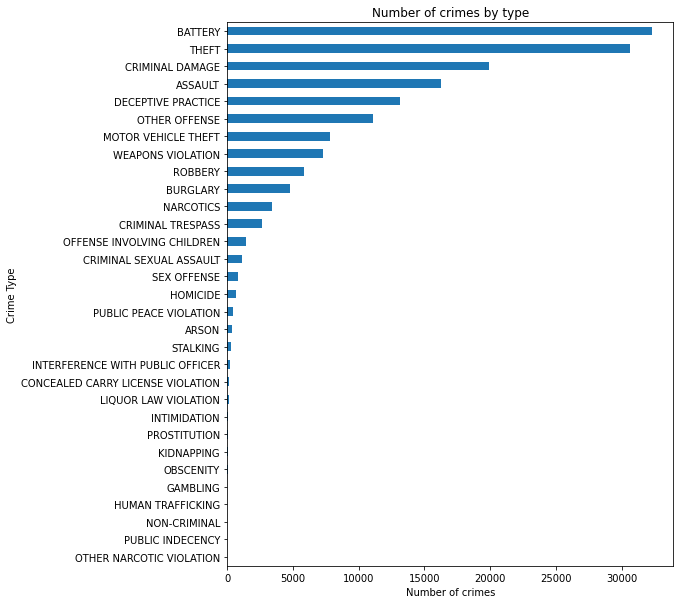

In [198]:
plt.figure(figsize=(8,10))
data21.groupby([data21['Primary Type']]).size().sort_values(ascending=True).plot(kind='barh')
plt.title('Number of crimes by type')
plt.ylabel('Crime Type')
plt.xlabel('Number of crimes')
plt.show()

In [203]:
# convert dates to pandas datetime format
data21.Date = pd.to_datetime(data21.Date, format='%m/%d/%Y %I:%M:%S %p')
# setting the index to be the date will help us a lot later on
data21.index = pd.DatetimeIndex(data21.Date)

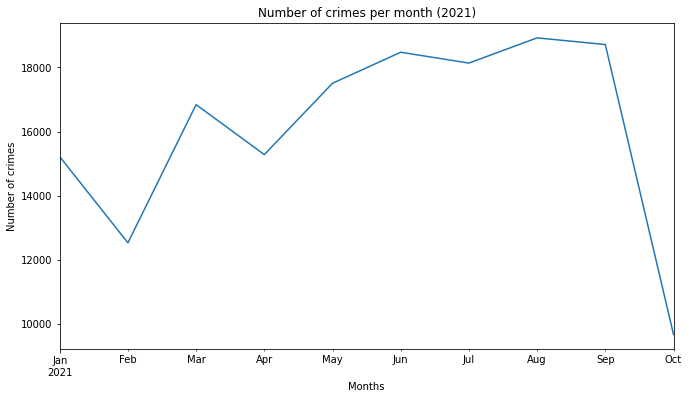

In [206]:
plt.figure(figsize=(11,6))
data21.resample('BM').size().plot(legend=False)
plt.title('Number of crimes per month (2021)')
plt.xlabel('Months')
plt.ylabel('Number of crimes')
plt.show()

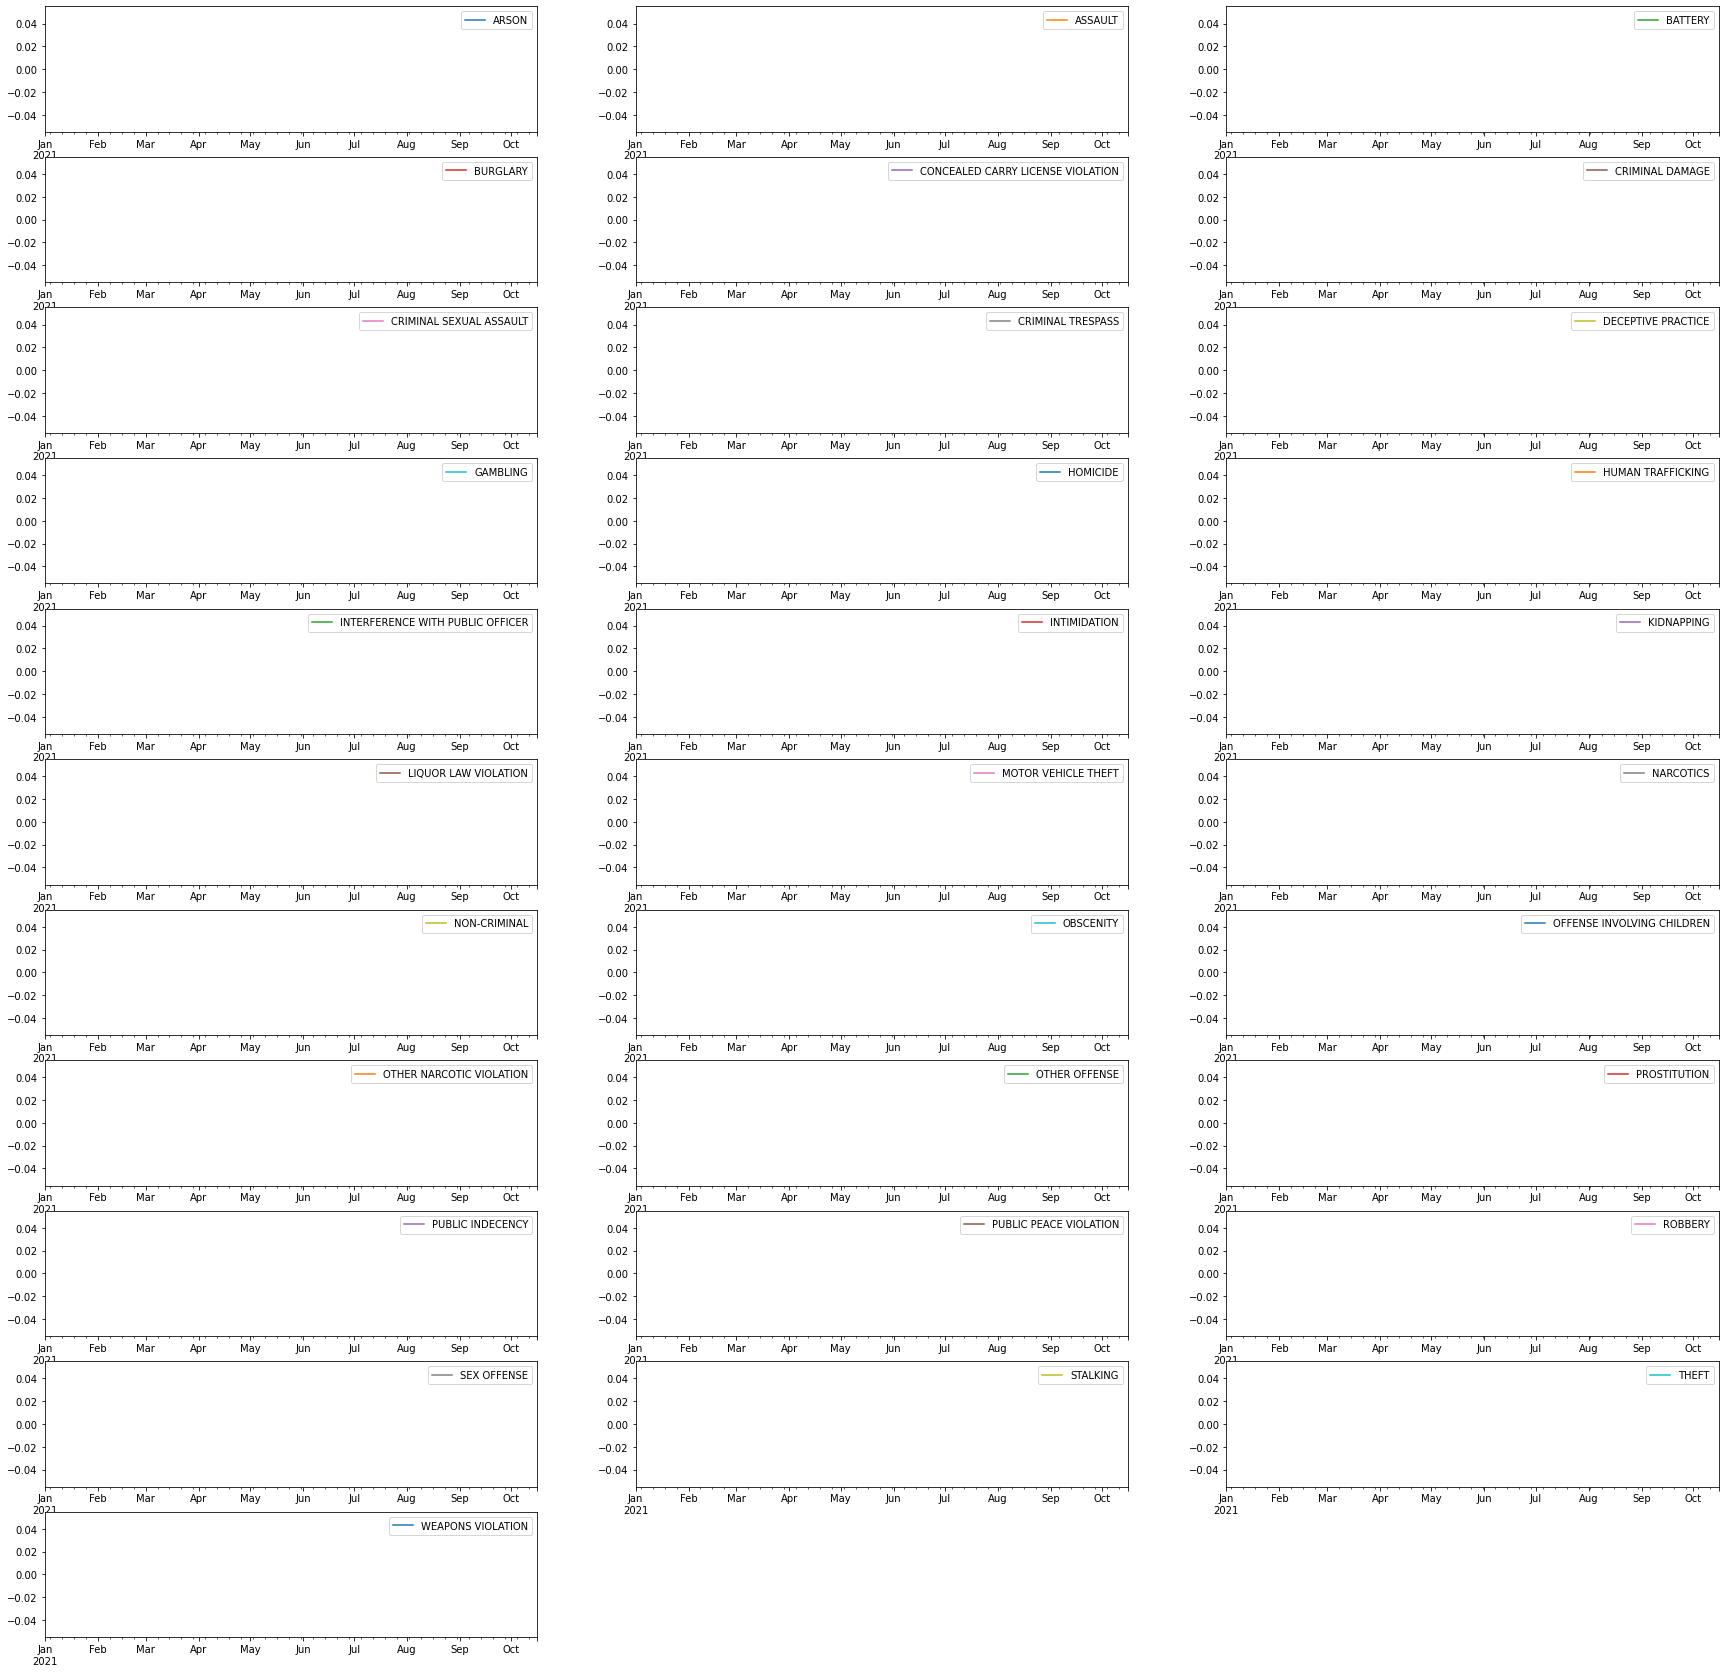

In [209]:
crimes_count_date = data21.pivot_table('ID', aggfunc=np.size, columns='Primary Type', index=data21.index.date, fill_value=0)
crimes_count_date.index = pd.DatetimeIndex(crimes_count_date.index)
plo = crimes_count_date.rolling(365).sum().plot(figsize=(30, 30), subplots=True, layout=(-1, 3), sharex=False, sharey=False)

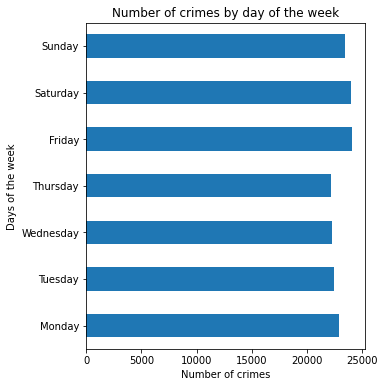

In [212]:
days = ['Monday','Tuesday','Wednesday',  'Thursday', 'Friday', 'Saturday', 'Sunday']
data21.groupby([data21.index.dayofweek]).size().plot(kind='barh', figsize=(5, 6))
plt.ylabel('Days of the week')
plt.yticks(np.arange(7), days)
plt.xlabel('Number of crimes')
plt.title('Number of crimes by day of the week')
plt.show()

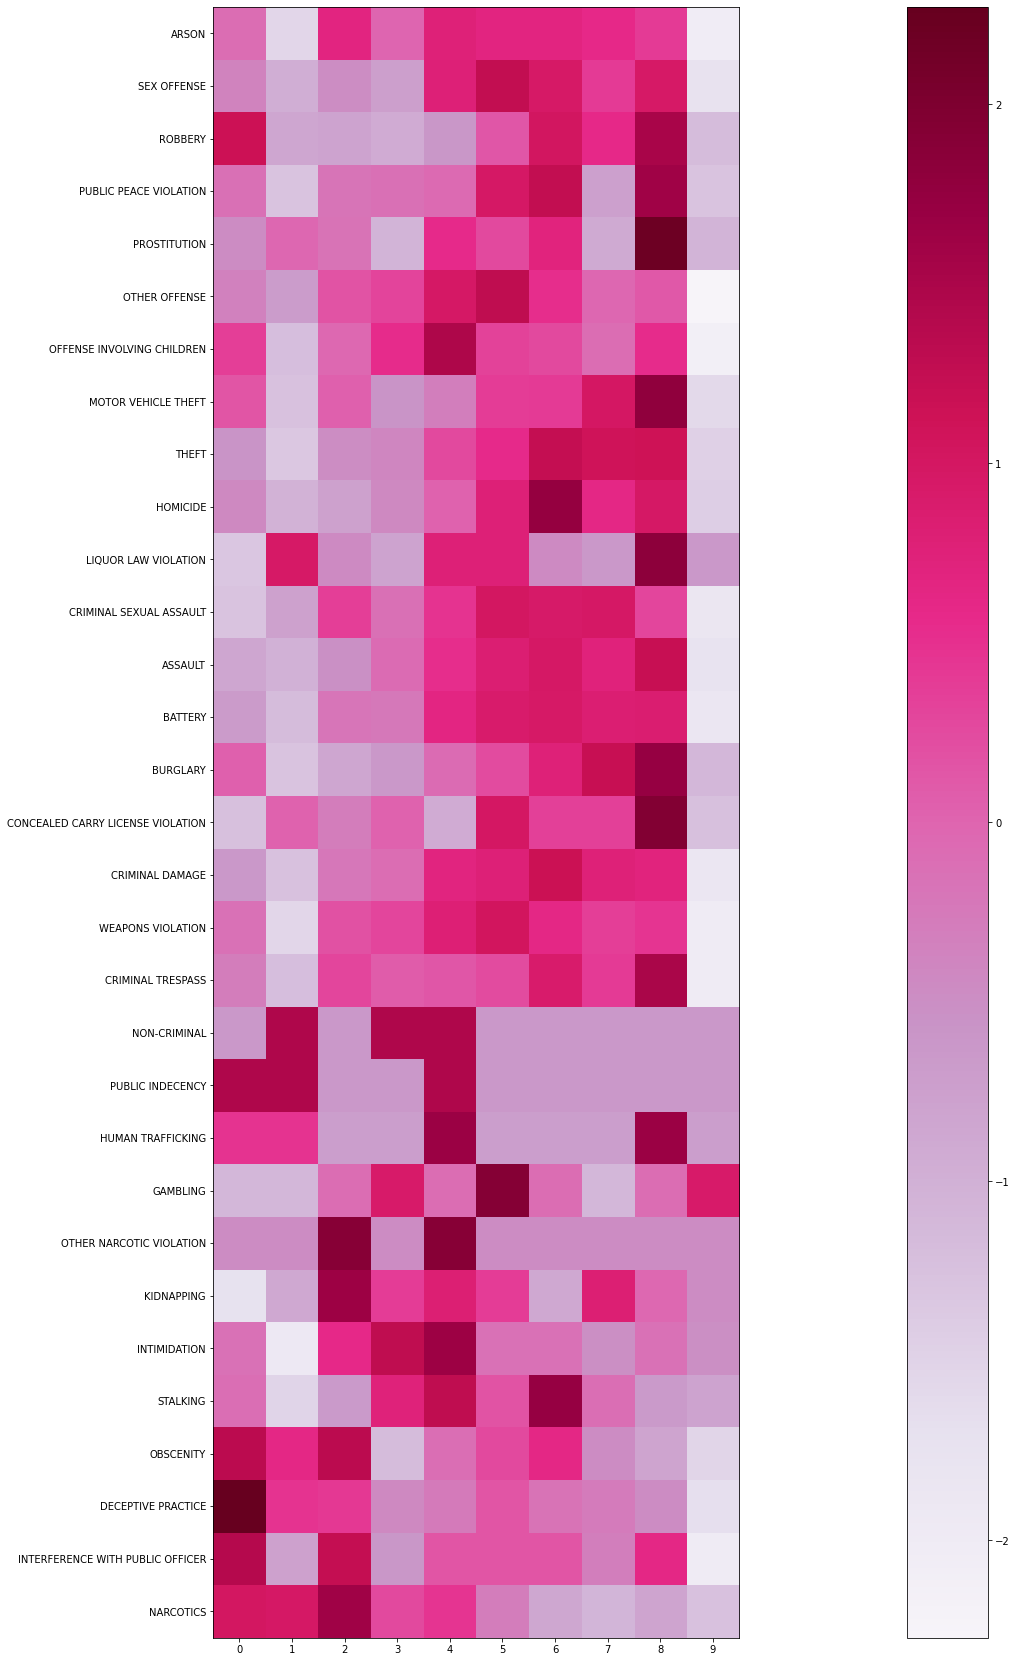

In [227]:
plt.figure(figsize=(60,30))
scale_and_plot(month_by_type)

In [213]:
hour_by_location = data21.pivot_table(values='ID', index='Location Description', columns=data21.index.hour, aggfunc=np.size).fillna(0)
hour_by_type     = data21.pivot_table(values='ID', index='Primary Type', columns=data21.index.hour, aggfunc=np.size).fillna(0)
dayofweek_by_type = data21.pivot_table(values='ID', index='Primary Type', columns=data21.index.dayofweek, aggfunc=np.size).fillna(0)
location_by_type  = data21.pivot_table(values='ID', index='Location Description', columns='Primary Type', aggfunc=np.size).fillna(0)

In [225]:
month_by_type     = data21.pivot_table(values='ID', index='Primary Type', columns=data21.index.month, aggfunc=np.size).fillna(0)

In [222]:
district_crimeType = data21.pivot_table(values='ID', index='Primary Type', columns=data21.District, aggfunc=np.size).fillna(0)

In [216]:
from sklearn.cluster import AgglomerativeClustering as AC

def scale_df(df,axis=0):
    return (df - df.mean(axis=axis)) / df.std(axis=axis)


def plot_hmap(df, ix=None, cmap='PuRd'):
    if ix is None:
        ix = np.arange(df.shape[0])
    plt.imshow(df.iloc[ix,:], cmap=cmap)
    plt.colorbar(fraction=0.03)
    plt.yticks(np.arange(df.shape[0]), df.index[ix])
    plt.xticks(np.arange(df.shape[1]))
    plt.grid(False)
    plt.show()
    
def scale_and_plot(df, ix = None):
    df_marginal_scaled = scale_df(df.T).T
    if ix is None:
        ix = AC(4).fit(df_marginal_scaled).labels_.argsort()
    cap = np.min([np.max(df_marginal_scaled.to_numpy()), np.abs(np.min(df_marginal_scaled.to_numpy()))])
    df_marginal_scaled = np.clip(df_marginal_scaled, -1*cap, cap)
    plot_hmap(df_marginal_scaled, ix=ix)

In [236]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
W = data21['ID'] 
X = data21['District']
Y = data21['Primary Type'] 
Z = data21['hour'] 
data = pd.DataFrame({'W': W, 'X': X, 'Y': Y, 'Z': Z}) 
data_pivoted = data.pivot("W", "X", "Y", "Z") 
ax = sns.heatmap(data_pivoted) 
plt.show()

#fuck this shityeah

fuck it
lets sleep

SyntaxError: invalid syntax (2043075409.py, line 15)

In [224]:
data21['District'].unique()

array([0.2       , 0.16666667, 0.46666667, 0.06666667, 0.1       ,
       0.36666667, 0.76666667, 0.03333333, 0.3       , 0.43333333,
       0.7       , 0.56666667, 0.13333333, 0.33333333, 0.26666667,
       0.63333333, 0.8       , 0.23333333, 0.53333333, 0.6       ,
       0.5       , 0.        , 1.        ])

/home/aomkar/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['float']. An error will be raised in 1.2.
  warnings.warn(


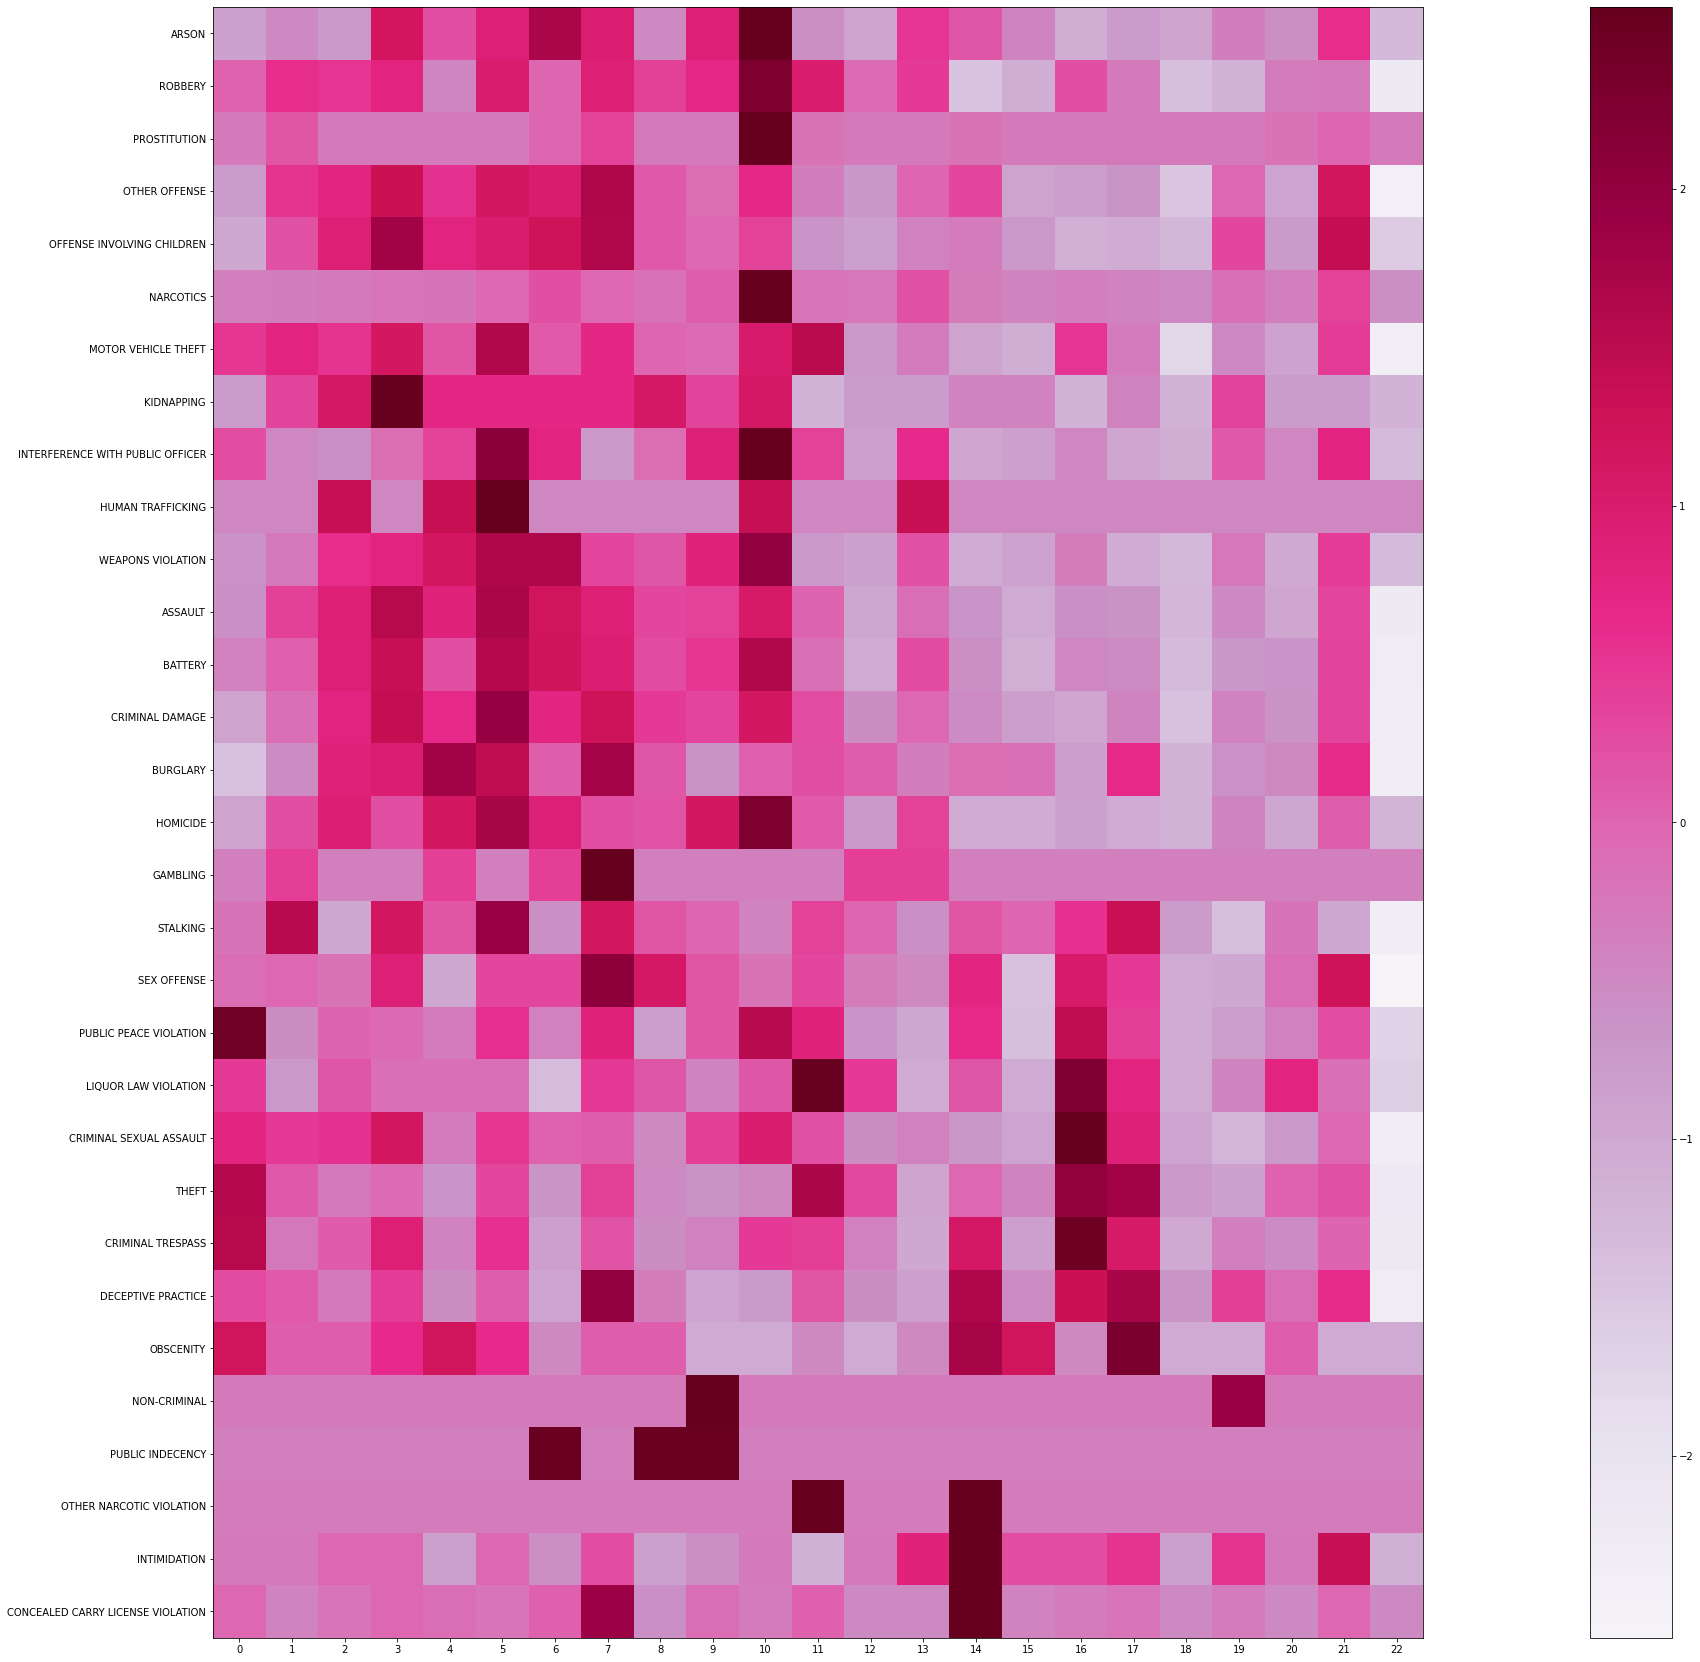

In [223]:
#district_crimeType
plt.figure(figsize=(60,30))
scale_and_plot(district_crimeType)

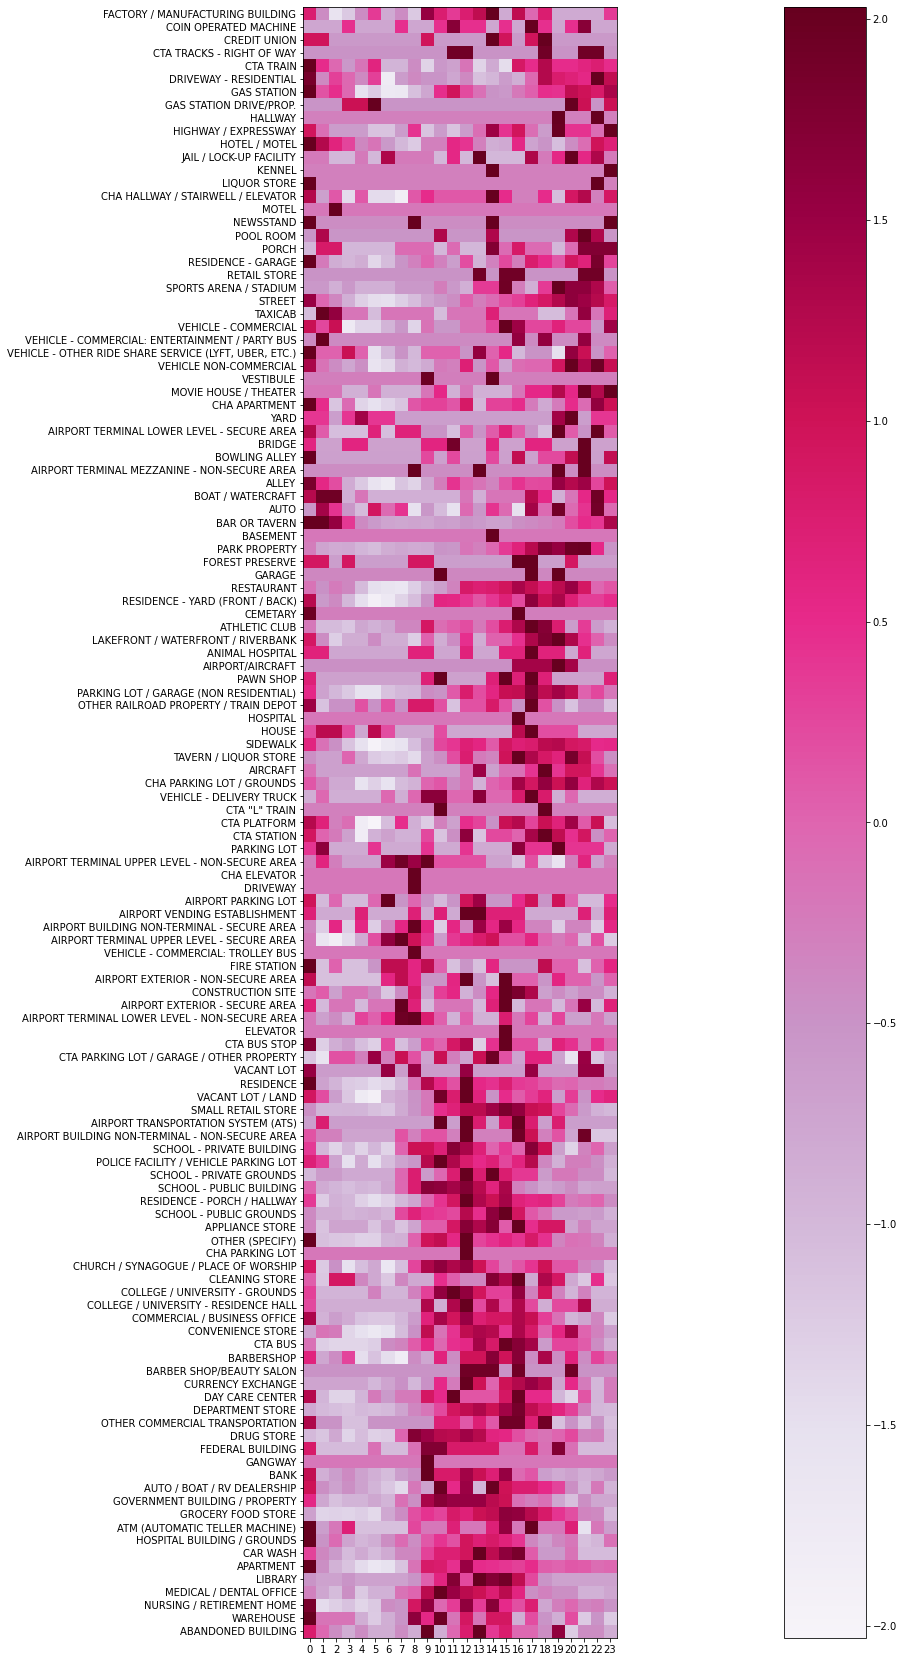

In [217]:
plt.figure(figsize=(60,30))
scale_and_plot(hour_by_location)

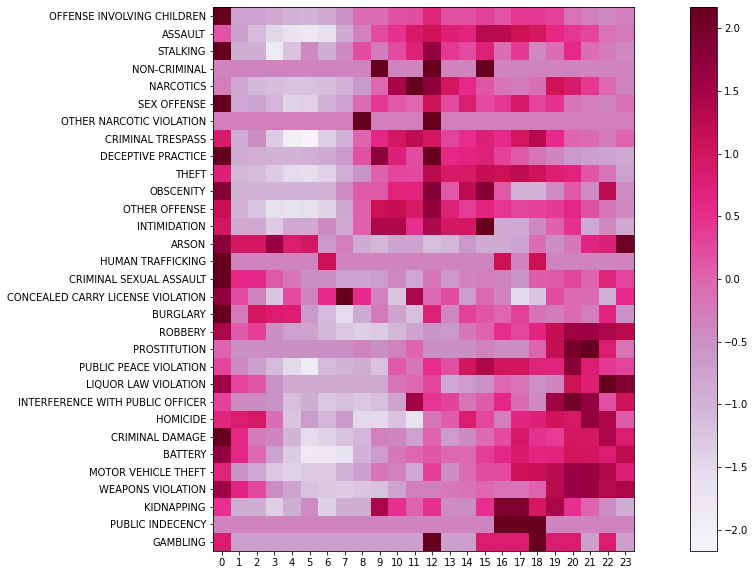

In [218]:
plt.figure(figsize=(20, 10))
scale_and_plot(hour_by_type)

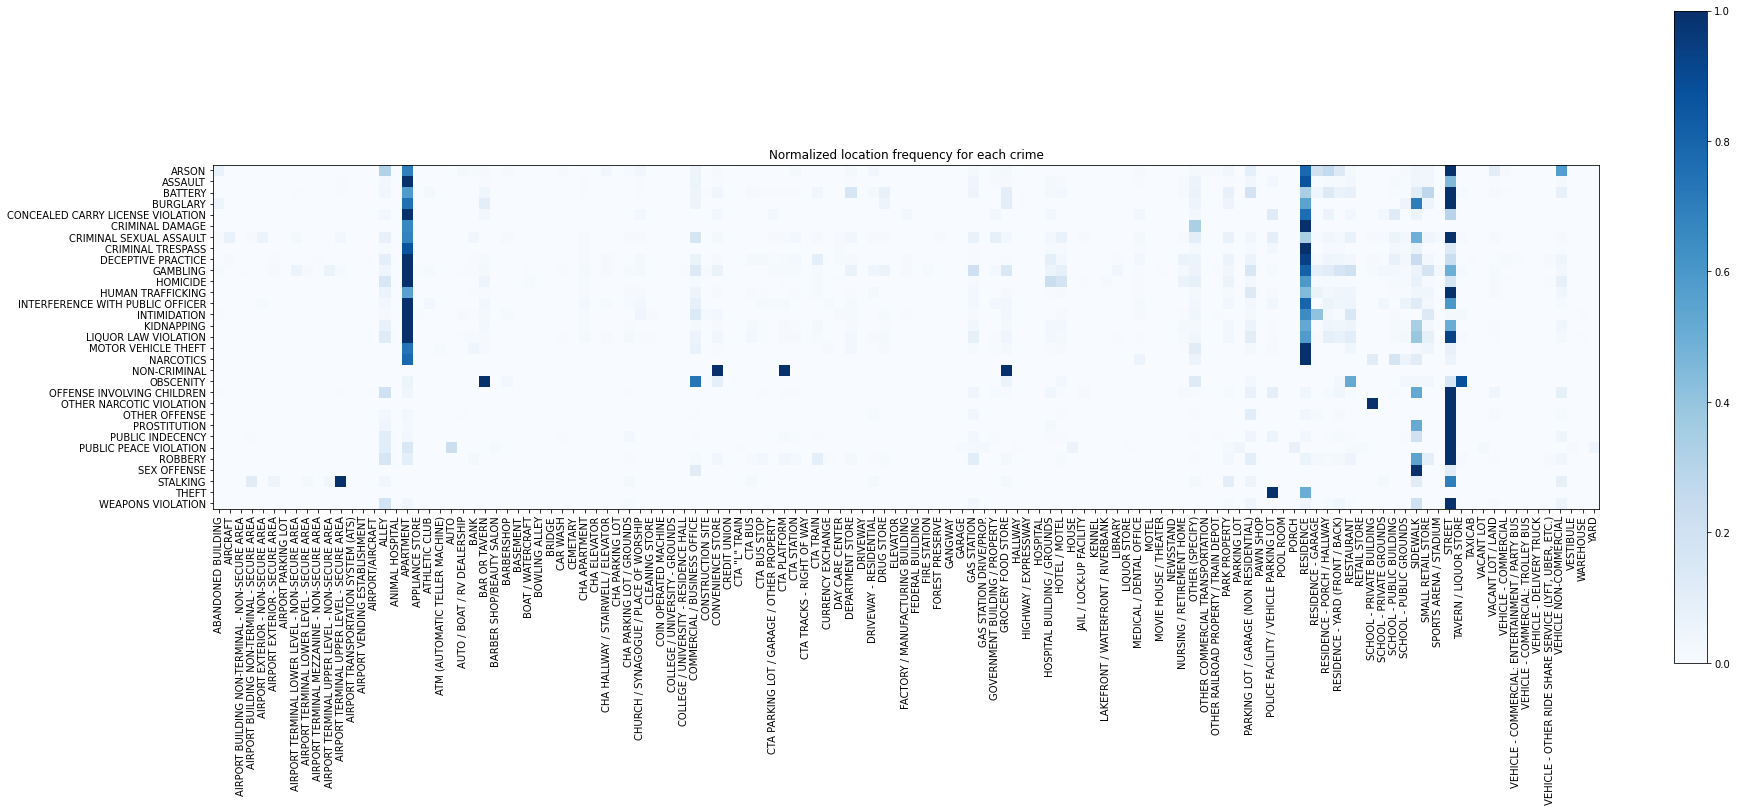

In [219]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

df = normalize(location_by_type)
ix = AC(3).fit(df.T).labels_.argsort() 
plt.figure(figsize=(27, 12))
plt.imshow(df.T.iloc[ix,:], cmap='Blues')
plt.colorbar(fraction=0.03)
plt.xticks(np.arange(df.shape[0]), df.index, rotation='vertical')
plt.yticks(np.arange(df.shape[1]), df.columns)
plt.title('Normalized location frequency for each crime')
plt.grid(False)
plt.show()

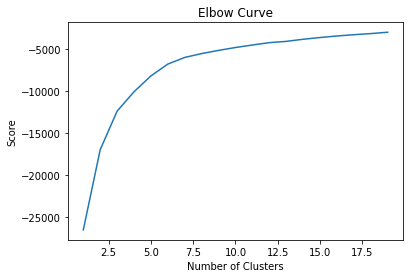

In [182]:
# KMEANS - IUCR vs DISTRICT

# Getting the data ready
sub_data1 = data21[['IUCR', 'District', 'seconds']] 

# Elbow
N = range(1, 20) 
kmeans = [KMeans(n_clusters=i) for i in N] 
# kmeans 
score = [kmeans[i].fit(sub_data1).score(sub_data1) for i in range(len(kmeans))]
# score 
plt.plot(N,score) 
plt.xlabel('Number of Clusters') 
plt.ylabel('Score') 
plt.title('Elbow Curve') 
plt.show() 

In [ ]:
#elbow seems to be 4

In [189]:
km = KMeans(n_clusters=3) 
km.fit(sub_data1) 
y = km.predict(sub_data1) 
labels = km.labels_ 
sub_data1['Clusters'] = y

/tmp/ipykernel_11401/301562898.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_data1['Clusters'] = y


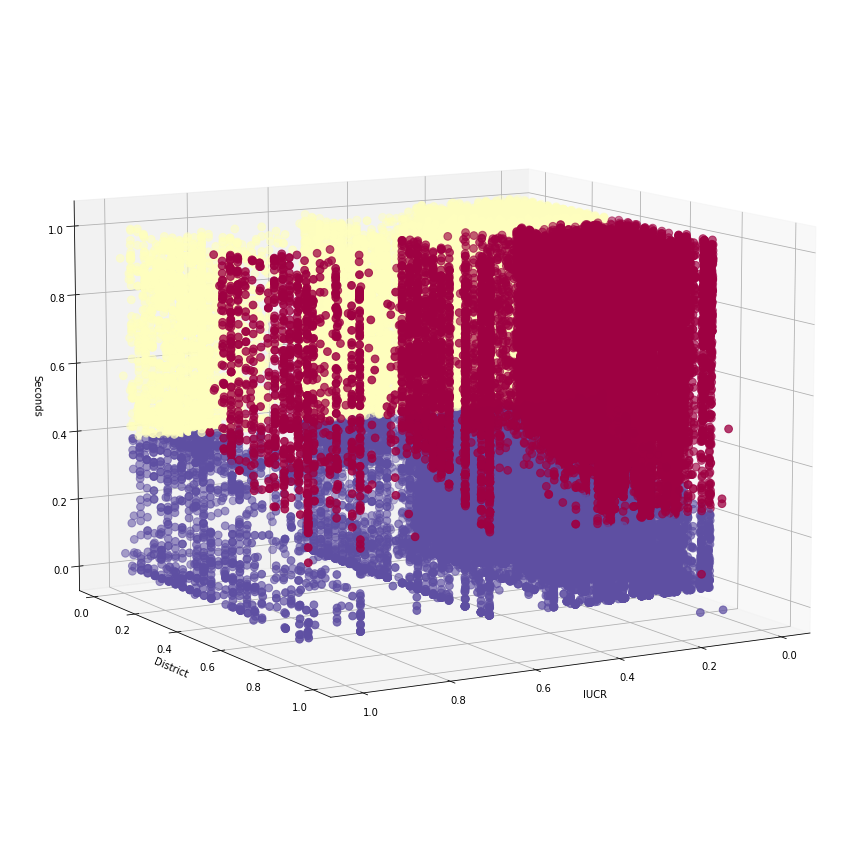

In [190]:
fig = plt.figure(figsize=(15,20)) 
ax = fig.add_subplot(111, projection='3d') 
x = np.array(sub_data1['IUCR']) 
y = np.array(sub_data1['District']) 
z = np.array(sub_data1['seconds']) 
ax.set_xlabel('IUCR') 
ax.set_ylabel('District') 
ax.set_zlabel('Seconds') 
ax.scatter(x,y,z, marker="o", c = sub_data1["Clusters"], s=60, cmap="Spectral") 
ax.view_init(elev=10., azim=60)
# ax.view_init(azim=0) 
# print(ax.azim) 
plt.show() 

/tmp/ipykernel_11401/886426311.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_data1['Clusters'] = y


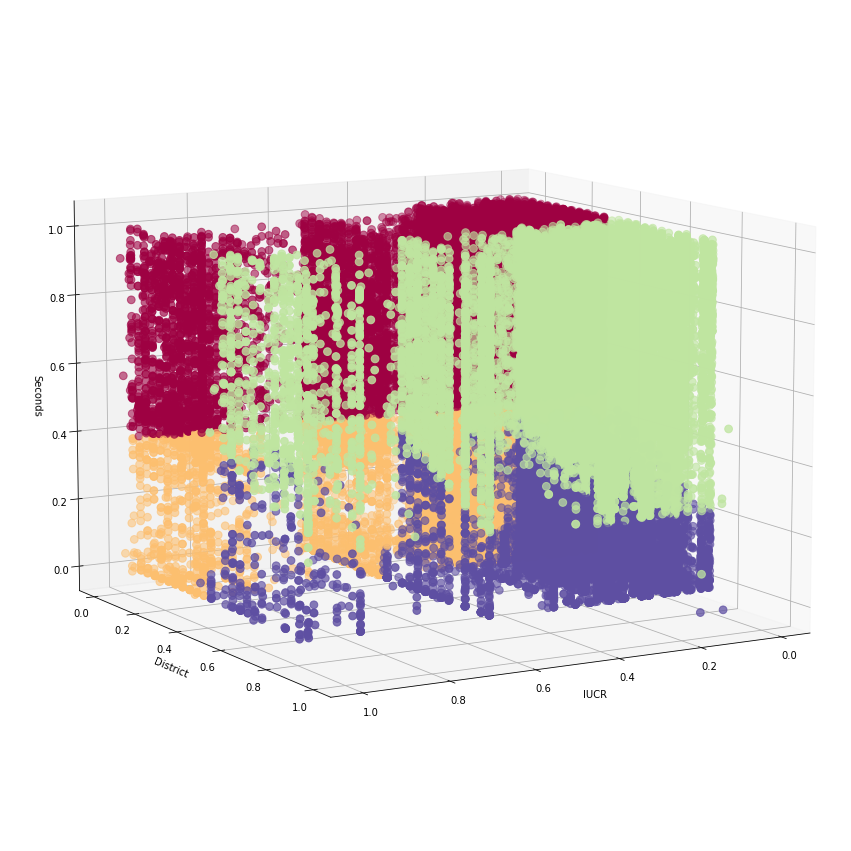

In [191]:
km = KMeans(n_clusters=4) 
km.fit(sub_data1) 
y = km.predict(sub_data1) 
labels = km.labels_ 
sub_data1['Clusters'] = y

fig = plt.figure(figsize=(15,20)) 
ax = fig.add_subplot(111, projection='3d') 
x = np.array(sub_data1['IUCR']) 
y = np.array(sub_data1['District']) 
z = np.array(sub_data1['seconds']) 
ax.set_xlabel('IUCR') 
ax.set_ylabel('District') 
ax.set_zlabel('Seconds') 
ax.scatter(x,y,z, marker="o", c = sub_data1["Clusters"], s=60, cmap="Spectral") 
ax.view_init(elev=10., azim=60)
# ax.view_init(azim=0) 
# print(ax.azim) 
plt.show() 

/tmp/ipykernel_11401/2361485502.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_data1['Clusters'] = y


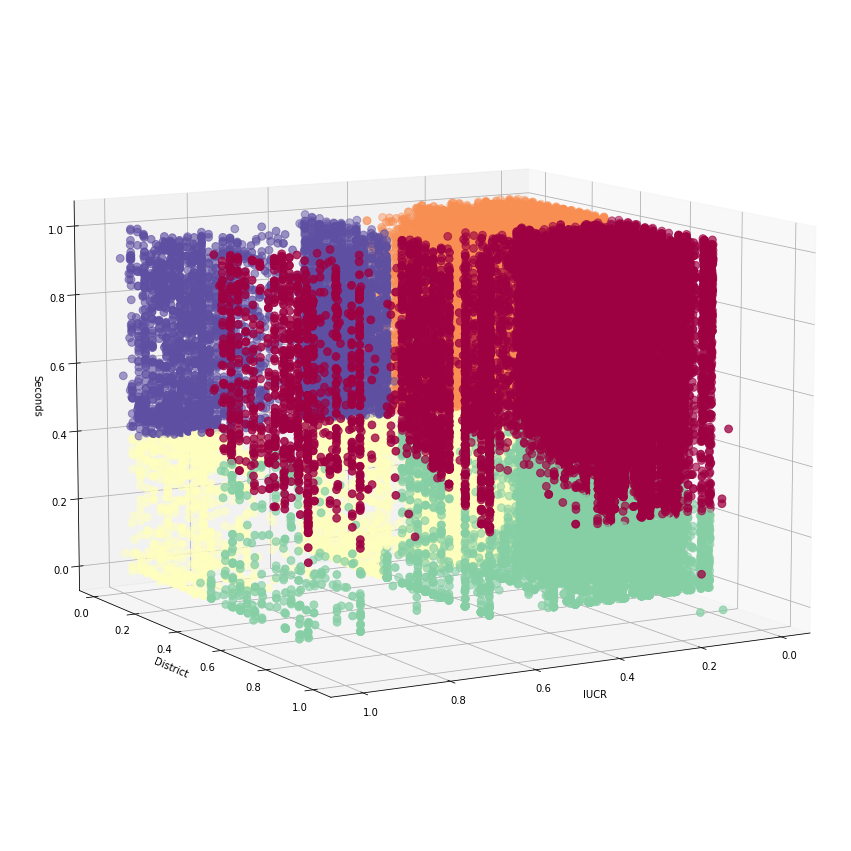

In [192]:
km = KMeans(n_clusters=5) 
km.fit(sub_data1) 
y = km.predict(sub_data1) 
labels = km.labels_ 
sub_data1['Clusters'] = y

fig = plt.figure(figsize=(15,20)) 
ax = fig.add_subplot(111, projection='3d') 
x = np.array(sub_data1['IUCR']) 
y = np.array(sub_data1['District']) 
z = np.array(sub_data1['seconds']) 
ax.set_xlabel('IUCR') 
ax.set_ylabel('District') 
ax.set_zlabel('Seconds') 
ax.scatter(x,y,z, marker="o", c = sub_data1["Clusters"], s=60, cmap="Spectral") 
ax.view_init(elev=10., azim=60)
# ax.view_init(azim=0) 
# print(ax.azim) 
plt.show() 

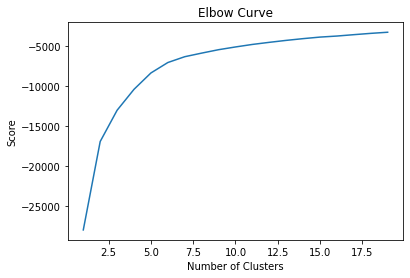

In [193]:
# KMEANS - IUCR vs month vs DISTRICT

# Getting the data ready
sub_data1 = data21[['IUCR', 'month', 'District']] 

# Elbow
N = range(1, 20) 
kmeans = [KMeans(n_clusters=i) for i in N] 
# kmeans 
score = [kmeans[i].fit(sub_data1).score(sub_data1) for i in range(len(kmeans))]
# score 
plt.plot(N,score) 
plt.xlabel('Number of Clusters') 
plt.ylabel('Score') 
plt.title('Elbow Curve') 
plt.show() 

/tmp/ipykernel_11401/1069397275.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_data1['Clusters'] = y


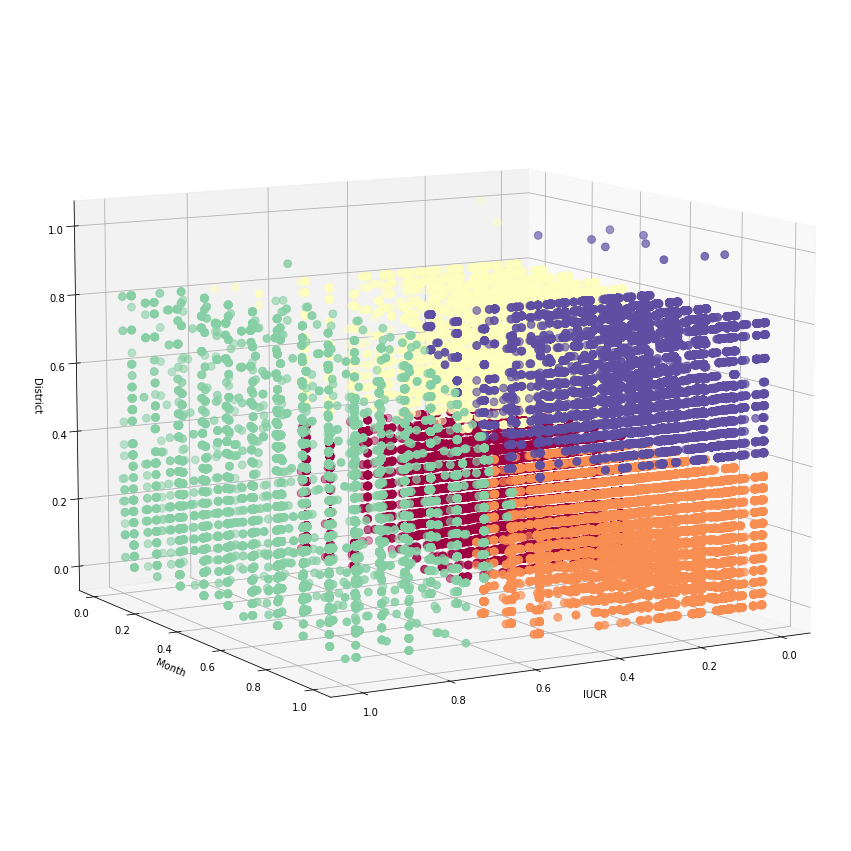

In [194]:
km = KMeans(n_clusters=5) 
km.fit(sub_data1) 
y = km.predict(sub_data1) 
labels = km.labels_ 
sub_data1['Clusters'] = y

fig = plt.figure(figsize=(15,20)) 
ax = fig.add_subplot(111, projection='3d') 
x = np.array(sub_data1['IUCR']) 
y = np.array(sub_data1['month']) 
z = np.array(sub_data1['District']) 
ax.set_xlabel('IUCR') 
ax.set_ylabel('Month') 
ax.set_zlabel('District') 
ax.scatter(x,y,z, marker="o", c = sub_data1["Clusters"], s=60, cmap="Spectral") 
ax.view_init(elev=10., azim=60)
# ax.view_init(azim=0) 
# print(ax.azim) 
plt.show() 

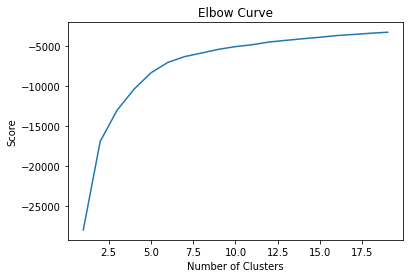

In [195]:
# KMEANS - IUCR vs month vs DISTRICT

# Getting the data ready
sub_data1 = data21[['IUCR', 'District', 'month']] 

# Elbow
N = range(1, 20) 
kmeans = [KMeans(n_clusters=i) for i in N] 
# kmeans 
score = [kmeans[i].fit(sub_data1).score(sub_data1) for i in range(len(kmeans))]
# score 
plt.plot(N,score) 
plt.xlabel('Number of Clusters') 
plt.ylabel('Score') 
plt.title('Elbow Curve') 
plt.show() 

/tmp/ipykernel_11401/3971499031.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_data1['Clusters'] = y


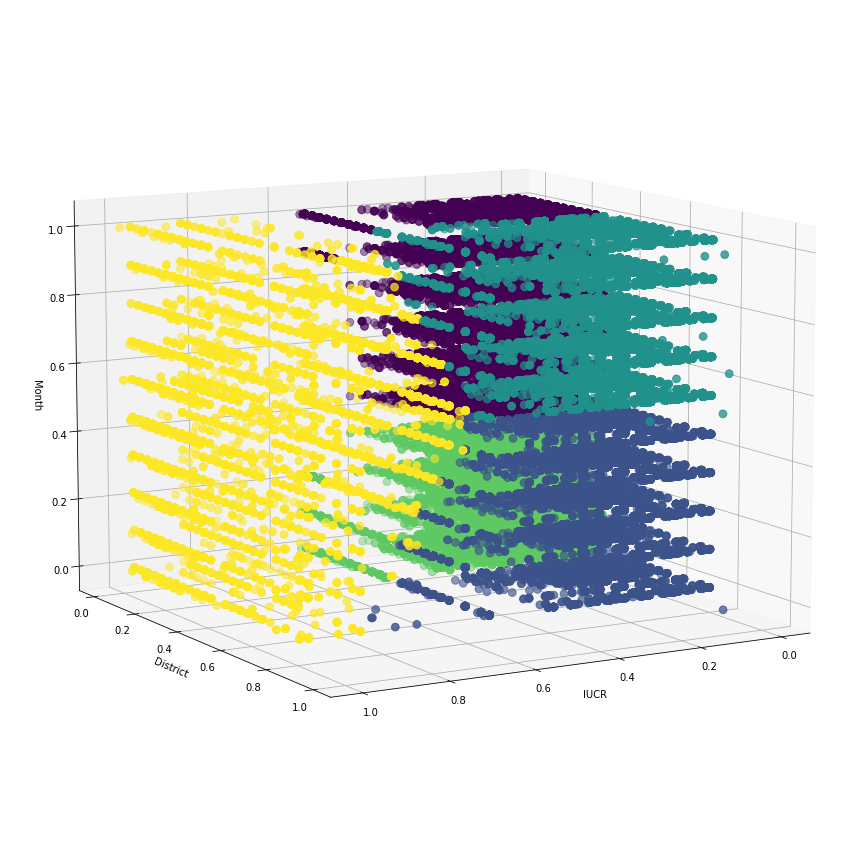

In [196]:
km = KMeans(n_clusters=5) 
km.fit(sub_data1) 
y = km.predict(sub_data1) 
labels = km.labels_ 
sub_data1['Clusters'] = y

fig = plt.figure(figsize=(15,20)) 
ax = fig.add_subplot(111, projection='3d') 
x = np.array(sub_data1['IUCR']) 
y = np.array(sub_data1['District']) 
z = np.array(sub_data1['month']) 
ax.set_xlabel('IUCR') 
ax.set_ylabel('District') 
ax.set_zlabel('Month') 
ax.scatter(x,y,z, marker="o", c = sub_data1["Clusters"], s=60, cmap="viridis") 
ax.view_init(elev=10., azim=60)
# ax.view_init(azim=0) 
# print(ax.azim) 
plt.show() 

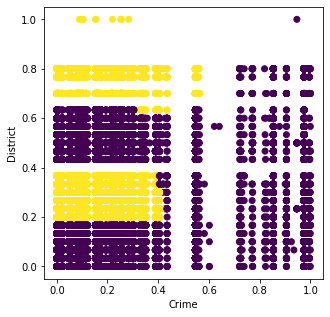

In [121]:
fig = plt.figure(figsize=(5,5)) 
# ax = fig.add_subplot(111, projection='2d') 
x = np.array(sub_data1['IUCR']) 
y = np.array(sub_data1['District']) 
# ax.set_xlabel('IUCR') 
# ax.set_ylabel('District') 
# ax.scatter(x,y,z, marker="o", c = sub_data1["Clusters"], s=60, cmap="Spectral") 
# ax.view_init(elev=10., azim=50)
# ax.view_init(azim=0) 
# print(ax.azim) 
# plt.scatter(x,y) 
# plt.scatter(x, y, s=None, c=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, *, edgecolors=None, plotnonfinite=False, data=None, **kwargs) 
plt.scatter(x,y, c=km.labels_)
plt.xlabel('Crime') 
plt.ylabel('District')
plt.show() 

In [112]:
km = KMeans(n_clusters=3) 
km.fit(sub_data1) 
y = km.predict(sub_data1) 
labels = km.labels_ 
sub_data1['Clusters'] = y

/tmp/ipykernel_11401/301562898.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_data1['Clusters'] = y


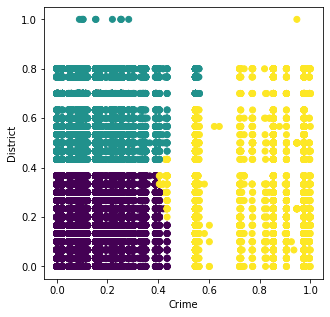

In [115]:
fig = plt.figure(figsize=(5,5)) 
# ax = fig.add_subplot(111, projection='2d') 
x = np.array(sub_data1['IUCR']) 
y = np.array(sub_data1['District']) 
# ax.set_xlabel('IUCR') 
# ax.set_ylabel('District') 
# ax.scatter(x,y,z, marker="o", c = sub_data1["Clusters"], s=60, cmap="Spectral") 
# ax.view_init(elev=10., azim=50)
# ax.view_init(azim=0) 
# print(ax.azim) 
# plt.scatter(x,y) 
# plt.scatter(x, y, s=None, c=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, *, edgecolors=None, plotnonfinite=False, data=None, **kwargs) 
plt.scatter(x,y, c=km.labels_)
plt.xlabel('Crime') 
plt.ylabel('District')
plt.show() 

In [179]:
sub_data1 = data21[['IUCR', 'District', 'seconds']] 
km = KMeans(n_clusters=4) 
km.fit(sub_data1) 
y = km.predict(sub_data1) 
labels = km.labels_ 
sub_data1['Clusters'] = y

/tmp/ipykernel_11401/2798809067.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_data1['Clusters'] = y


In [184]:

fig = plt.figure(figsize=(5,5)) 
ax = fig.add_subplot(111, projection='3d') 
x = np.array(sub_data1['IUCR']) 
y = np.array(sub_data1['District'])
z = np.array(sub_data1['seconds'])
ax.set_ylabel('District') 
ax.set_xlabel('IUCR') 
ax.set_zlabel('Time') 
ax.scatter(x,y,z, marker="o", c = sub_data1["Clusters"], s=60, cmap="Spectral") 
ax.(elev=10., azim=50)
ax.view_init(azim=0) 
# print(ax.azim) 
# plt.scatter(x,y) 
# plt.scatter(x, y, s=None, c=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=None
#plt.scatter(x,y, c=km.labels_)
# plt.xlabel('Crime')
# plt.ylabel('District')

plt.show()

#Seems to be clustering based on the value of district
#The clustes look like - crimes from 1 - 4 occur in all the districts, crimes from 6-1 also occur in all districts, makes no sense

SyntaxError: invalid syntax (2874159051.py, line 10)

In [118]:
km = KMeans(n_clusters=5) 
km.fit(sub_data1) 
y = km.predict(sub_data1) 
labels = km.labels_ 
sub_data1['Clusters'] = y

/tmp/ipykernel_11401/2371930434.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_data1['Clusters'] = y


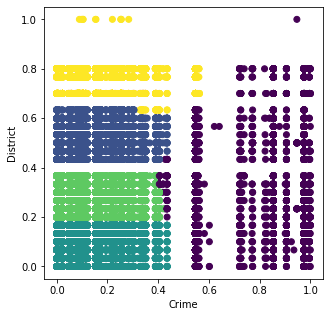

In [119]:
fig = plt.figure(figsize=(5,5)) 
# ax = fig.add_subplot(111, projection='2d') 
x = np.array(sub_data1['IUCR']) 
y = np.array(sub_data1['District']) 
# ax.set_xlabel('IUCR') 
# ax.set_ylabel('District') 
# ax.scatter(x,y,z, marker="o", c = sub_data1["Clusters"], s=60, cmap="Spectral") 
# ax.view_init(elev=10., azim=50)
# ax.view_init(azim=0) 
# print(ax.azim) 
# plt.scatter(x,y) 
# plt.scatter(x, y, s=None, c=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, *, edgecolors=None, plotnonfinite=False, data=None, **kwargs) 
plt.scatter(x,y, c=km.labels_)
plt.xlabel('Crime') 
plt.ylabel('District')
plt.show() 

/tmp/ipykernel_11401/3358168705.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_data1['Clusters'] = y


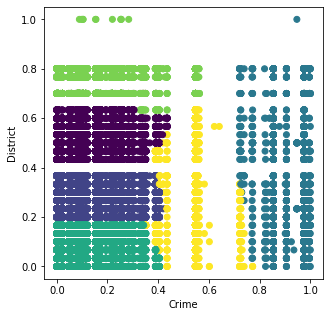

In [122]:
km = KMeans(n_clusters=6) 
km.fit(sub_data1) 
y = km.predict(sub_data1) 
labels = km.labels_ 
sub_data1['Clusters'] = y

fig = plt.figure(figsize=(5,5)) 
# ax = fig.add_subplot(111, projection='2d') 
x = np.array(sub_data1['IUCR']) 
y = np.array(sub_data1['District']) 
# ax.set_xlabel('IUCR') 
# ax.set_ylabel('District') 
# ax.scatter(x,y,z, marker="o", c = sub_data1["Clusters"], s=60, cmap="Spectral") 
# ax.view_init(elev=10., azim=50)
# ax.view_init(azim=0) 
# print(ax.azim) 
# plt.scatter(x,y) 
# plt.scatter(x, y, s=None, c=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, *, edgecolors=None, plotnonfinite=False, data=None, **kwargs) 
plt.scatter(x,y, c=km.labels_)
plt.xlabel('Crime') 
plt.ylabel('District')
plt.show() 

In [ ]:
#Crime, district


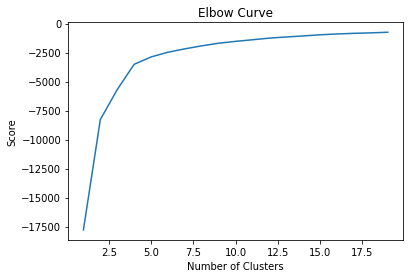

In [172]:
# KMEANS - IUCR vs time of day

# Getting the data ready
sub_data1 = data21[['IUCR', 'seconds']] 

# Elbow
N = range(1, 20) 
kmeans = [KMeans(n_clusters=i) for i in N] 
# kmeans 
score = [kmeans[i].fit(sub_data1).score(sub_data1) for i in range(len(kmeans))]
# score 
plt.plot(N,score) 
plt.xlabel('Number of Clusters') 
plt.ylabel('Score') 
plt.title('Elbow Curve') 
plt.show() 

In [173]:
km = KMeans(n_clusters=4) 
km.fit(sub_data1) 
y = km.predict(sub_data1) 
labels = km.labels_ 
sub_data1['Clusters'] = y



/tmp/ipykernel_11401/3546728434.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_data1['Clusters'] = y


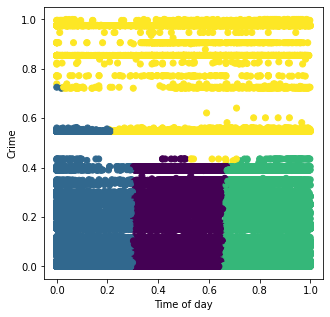

In [175]:
fig = plt.figure(figsize=(5,5)) 
# ax = fig.add_subplot(111, projection='2d') 
y = np.array(sub_data1['IUCR']) 
x = np.array(sub_data1['seconds']) 
# ax.set_xlabel('IUCR') 
# ax.set_ylabel('District') 
# ax.scatter(x,y,z, marker="o", c = sub_data1["Clusters"], s=60, cmap="Spectral") 
# ax.view_init(elev=10., azim=50)
# ax.view_init(azim=0) 
# print(ax.azim) 
# plt.scatter(x,y) 
# plt.scatter(x, y, s=None, c=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, *, edgecolors=None, plotnonfinite=False, data=None, **kwargs) 
plt.scatter(x,y, c=km.labels_)
plt.xlabel('Time of day') 
plt.ylabel('Crime')
plt.show()

In [161]:
#yayy

months = data21['month'].unique()
crimes_per_month = {}
for i, month in enumerate(months):
    crimes_per_month[str(month)] = 0
    
#for record in data21:
    

In [162]:
crimes_per_month

{'0.0': 0,
 '0.1111111111111111': 0,
 '0.3333333333333333': 0,
 '0.2222222222222222': 0,
 '0.4444444444444444': 0,
 '0.5555555555555556': 0,
 '0.6666666666666666': 0,
 '0.7777777777777778': 0,
 '0.8888888888888888': 0,
 '1.0': 0}

In [163]:
for record in data21['month']:
    crimes_per_month[str(record)] += 1

In [164]:
crimes_per_month

{'0.0': 16014,
 '0.1111111111111111': 12854,
 '0.3333333333333333': 15280,
 '0.2222222222222222': 15718,
 '0.4444444444444444': 17504,
 '0.5555555555555556': 18472,
 '0.6666666666666666': 18912,
 '0.7777777777777778': 18142,
 '0.8888888888888888': 18712,
 '1.0': 9675}

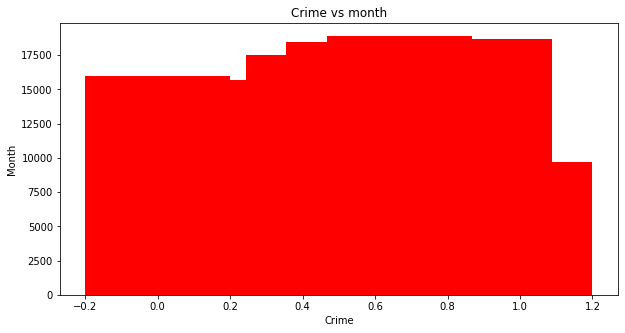

In [166]:
fig = plt.figure(figsize = (10, 5))
 
# creating the bar plot
plt.bar(months, crimes_per_month.values(), color ='red',
        width = 0.4)
 
plt.xlabel("Crime")
plt.ylabel("Month")
plt.title("Crime vs month")
plt.show()

In [135]:
data21['month'].unique()

array([0.        , 0.11111111, 0.33333333, 0.22222222, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

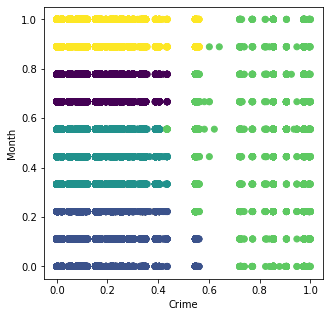

In [136]:
fig = plt.figure(figsize=(5,5)) 
# ax = fig.add_subplot(111, projection='2d') 
x = np.array(sub_data1['IUCR']) 
y = np.array(sub_data1['month']) 
# ax.set_xlabel('IUCR') 
# ax.set_ylabel('District') 
# ax.scatter(x,y,z, marker="o", c = sub_data1["Clusters"], s=60, cmap="Spectral") 
# ax.view_init(elev=10., azim=50)
# ax.view_init(azim=0) 
# print(ax.azim) 
# plt.scatter(x,y) 
# plt.scatter(x, y, s=None, c=None, marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=None, linewidths=None, *, edgecolors=None, plotnonfinite=False, data=None, **kwargs) 
plt.scatter(x,y, c=km.labels_)
plt.xlabel('Crime') 
plt.ylabel('Month')
plt.show() 

/tmp/ipykernel_11401/3595226167.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_data1['Clusters'] = y


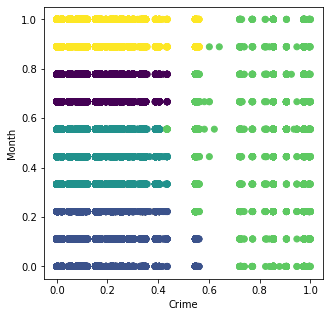

In [129]:
km = KMeans(n_clusters=5) 
km.fit(sub_data1) 
y = km.predict(sub_data1) 
labels = km.labels_ 
sub_data1['Clusters'] = y

 

In [130]:
data21['month'].iloc[0]

0.0

In [131]:
d.uni

6910067    0.0
6927871    0.0
6927960    0.0
6932002    0.0
6932007    0.0
          ... 
7423480    1.0
7423481    1.0
7423482    0.0
7423483    1.0
7423484    1.0
Name: month, Length: 161283, dtype: float64

In [ ]:
# KMEANS - IUCR vs MONTH

# Getting the data ready
sub_data1 = data21[['IUCR', 'hour']] 

# Elbow
N = range(1, 20) 
kmeans = [KMeans(n_clusters=i) for i in N] 
# kmeans 
score = [kmeans[i].fit(sub_data1).score(sub_data1) for i in range(len(kmeans))]
# score 
plt.plot(N,score) 
plt.xlabel('Number of Clusters') 
plt.ylabel('Score') 
plt.title('Elbow Curve') 
plt.show() 

In [85]:
data21

,ID,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,District,Ward,Community Area,Year,Location,date,month,time,hour,seconds
6910067,12260346,2021-01-03 13:23:00,070XX S EGGLESTON AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,0.200000,6.0,68.0,2021,"(41.766435144, -87.635963997)",2021-01-03,0.0,13:23:00,0.565217,0.558026
6927871,12263464,2021-01-03 06:59:00,080XX S YALE AVE,0820,THEFT,$500 AND UNDER,RESIDENCE,False,False,0.166667,17.0,44.0,2021,"(41.748473982, -87.630606588)",2021-01-03,0.0,06:59:00,0.260870,0.291174
6927960,12259990,2021-01-03 00:20:00,056XX W WASHINGTON BLVD,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,0.466667,29.0,25.0,2021,"(41.88222427, -87.766076162)",2021-01-03,0.0,00:20:00,0.000000,0.013899
6932002,12260669,2021-01-03 20:47:00,057XX S RACINE AVE,2022,NARCOTICS,POSSESS - COCAINE,STREET,True,False,0.200000,16.0,67.0,2021,"(41.79006908, -87.654768679)",2021-01-03,0.0,20:47:00,0.869565,0.866574
6932007,25702,2021-01-03 20:09:00,068XX S STONY ISLAND AVE,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,False,False,0.066667,5.0,43.0,2021,"(41.771062488, -87.586270811)",2021-01-03,0.0,20:09:00,0.869565,0.840167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7423480,12514897,2021-10-16 11:30:00,030XX N MILWAUKEE AVE,0460,BATTERY,SIMPLE,SCHOOL - PRIVATE BUILDING,False,False,0.800000,30.0,21.0,2021,"(41.936657276, -87.719850766)",2021-10-16,1.0,11:30:00,0.478261,0.479500
7423481,12514271,2021-10-16 16:00:00,025XX W MARQUETTE RD,1365,CRIMINAL TRESPASS,TO RESIDENCE,APARTMENT,False,False,0.233333,16.0,66.0,2021,"(41.771926901, -87.686706738)",2021-10-16,1.0,16:00:00,0.695652,0.667130
7423482,12517486,2021-01-02 00:00:00,114XX S FOREST AVE,1154,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT $300 AND UNDER,RESIDENCE,False,False,0.133333,9.0,49.0,2021,"(41.686439349, -87.615623747)",2021-01-02,0.0,00:00:00,0.000000,0.000000
7423483,12513899,2021-10-16 00:00:00,063XX S KOLIN AVE,0560,ASSAULT,SIMPLE,APARTMENT,False,True,0.233333,13.0,65.0,2021,"(41.777410704, -87.731273331)",2021-10-16,1.0,00:00:00,0.000000,0.000000


In [81]:
data21.iloc[0]

ID                                           12260346
Date                              2021-01-03 13:23:00
Block                           070XX S EGGLESTON AVE
IUCR                                             0486
Primary Type                                  BATTERY
Description                   DOMESTIC BATTERY SIMPLE
Location Description                        APARTMENT
Arrest                                          False
Domestic                                         True
District                                          0.2
Ward                                              6.0
Community Area                                   68.0
Year                                             2021
Location                (41.766435144, -87.635963997)
date                                       2021-01-03
month                                             0.0
time                                         13:23:00
hour                                         0.565217
seconds                     

In [82]:
data21.head()

,ID,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,District,Ward,Community Area,Year,Location,date,month,time,hour,seconds
6910067,12260346,2021-01-03 13:23:00,070XX S EGGLESTON AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,0.200000,6.0,68.0,2021,"(41.766435144, -87.635963997)",2021-01-03,0.0,13:23:00,0.565217,0.558026
6927871,12263464,2021-01-03 06:59:00,080XX S YALE AVE,0820,THEFT,$500 AND UNDER,RESIDENCE,False,False,0.166667,17.0,44.0,2021,"(41.748473982, -87.630606588)",2021-01-03,0.0,06:59:00,0.260870,0.291174
6927960,12259990,2021-01-03 00:20:00,056XX W WASHINGTON BLVD,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,0.466667,29.0,25.0,2021,"(41.88222427, -87.766076162)",2021-01-03,0.0,00:20:00,0.000000,0.013899
6932002,12260669,2021-01-03 20:47:00,057XX S RACINE AVE,2022,NARCOTICS,POSSESS - COCAINE,STREET,True,False,0.200000,16.0,67.0,2021,"(41.79006908, -87.654768679)",2021-01-03,0.0,20:47:00,0.869565,0.866574
6932007,25702,2021-01-03 20:09:00,068XX S STONY ISLAND AVE,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,False,False,0.066667,5.0,43.0,2021,"(41.771062488, -87.586270811)",2021-01-03,0.0,20:09:00,0.869565,0.840167


In [83]:
data21[6910067]

KeyError: 6910067

In [84]:
data21[0]

KeyError: 0

In [67]:
data21.iloc[161282]

Date                             2021-10-16 10:15:00
Block                                036XX W 16TH ST
IUCR                                            1310
Primary Type                         CRIMINAL DAMAGE
Description                              TO PROPERTY
Location Description              SMALL RETAIL STORE
Arrest                                         False
Domestic                                       False
District                                         0.3
Ward                                            24.0
Community Area                                  29.0
Year                                            2021
Location                (41.858965656, -87.71585846)
date                                      2021-10-16
month                                            1.0
time                                        10:15:00
hour                                        0.434783
seconds                                      0.42738
Name: 7423484, dtype: object

In [47]:
data21['IUCR'].iloc[1]

'0820'

In [48]:
data21['IUCR'].iloc[0] - data21['IUCR'].iloc[1]

TypeError: unsupported operand type(s) for -: 'str' and 'str'

In [49]:
int(data21['IUCR'].iloc[0])

486

In [90]:
data21[data21['ID'] == 12260693]

,ID,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,District,Ward,Community Area,Year,Location,date,month,time,hour,seconds
6940555,12260693,2021-01-03 23:47:00,016XX E 69TH ST,141A,WEAPONS VIOLATION,UNLAWFUL USE - HANDGUN,STREET,False,False,0.066667,5.0,43.0,2021,"(41.769708488, -87.585263769)",2021-01-03,0.0,23:47:00,1.0,0.991661


In [92]:
data21[data21['ID'] == 12260693]

,ID,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,District,Ward,Community Area,Year,Location,date,month,time,hour,seconds
6940555,12260693,2021-01-03 23:47:00,016XX E 69TH ST,141,WEAPONS VIOLATION,UNLAWFUL USE - HANDGUN,STREET,False,False,0.066667,5.0,43.0,2021,"(41.769708488, -87.585263769)",2021-01-03,0.0,23:47:00,1.0,0.991661


In [91]:
data21['IUCR'] = data21.IUCR.str.extract('(\d+)', expand=True).astype(int)

In [88]:
print(data21[data21['IUCR'] == '141A'])

               ID                Date                     Block  IUCR  \
6940555  12260693 2021-01-03 23:47:00           016XX E 69TH ST  141A   
7026685  12262059 2021-01-05 14:43:00       062XX S LANGLEY AVE  141A   
7028252  12263698 2021-01-07 14:59:00       043XX S ROCKWELL ST  141A   
7028440  12264069 2021-01-07 19:13:00           004XX E 87TH ST  141A   
7030543  12261490 2021-01-05 01:31:00         023XX N MEADE AVE  141A   
...           ...                 ...                       ...   ...   
7421798  12511560 2021-10-14 03:45:00        080XX S DOBSON AVE  141A   
7422499  12512784 2021-10-15 09:43:00   043XX W WASHINGTON BLVD  141A   
7423039  12514046 2021-10-16 17:50:00       055XX W POTOMAC AVE  141A   
7423247  12513437 2021-10-16 00:50:00  075XX S STONY ISLAND AVE  141A   
7423273  12514115 2021-10-16 20:27:00           013XX W 87TH ST  141A   

              Primary Type             Description  \
6940555  WEAPONS VIOLATION  UNLAWFUL USE - HANDGUN   
7026685  WEAPON

In [50]:
data21['IUCR'].unique()

array(['0486', '0820', '2022', '0110', '0560', '141A', '1310', '1360',
       '1154', '0460', '0325', '0860', '0610', '0910', '1320', '041A',
       '2027', '2026', '1152', '1581', '0497', '1812', '4387', '0810',
       '0890', '143A', '2024', '1130', '0454', '2820', '5002', '1345',
       '1330', '051A', '2826', '0620', '1150', '1153', '0870', '0530',
       '1750', '2093', '2825', '0420', '0430', '0520', '1305', '0320',
       '1811', '2021', '1570', '1242', '0496', '0330', '1477', '031A',
       '502R', '4386', '0557', '501A', '1156', '0880', '1822', '0453',
       '2028', '1210', '0487', '5011', '0930', '2870', '1365', '3731',
       '5110', '0326', '0498', '4389', '1780', '1563', '0340', '1170',
       '5000', '0580', '0550', '0495', '0261', '0630', '1340', '0917',
       '0484', '033A', '4625', '1020', '0483', '5112', '0479', '0865',
       '1120', '051B', '502P', '2025', '0281', '141B', '1155', '1110',
       '0312', '2890', '0440', '1512', '5001', '1185', '5111', '0470',
      

In [94]:
for s in data21['IUCR'].unique():
    s = str(s)
    if not s.isnumeric():
        print(s)
#         print(type(s))

In [74]:
i = 0
for s in data21['IUCR']:
    if not s.isnumeric():
        print(data21.iloc[i])
        break
    else:
        i+=1

ID                                           12260693
Date                              2021-01-03 23:47:00
Block                                 016XX E 69TH ST
IUCR                                             141A
Primary Type                        WEAPONS VIOLATION
Description                    UNLAWFUL USE - HANDGUN
Location Description                           STREET
Arrest                                          False
Domestic                                        False
District                                     0.066667
Ward                                              5.0
Community Area                                   43.0
Year                                             2021
Location                (41.769708488, -87.585263769)
date                                       2021-01-03
month                                             0.0
time                                         23:47:00
hour                                              1.0
seconds                     

In [58]:
a = '500E'
b = a.extract('(\d+)', expand=True).astype(int)
print(b)

AttributeError: 'str' object has no attribute 'extract'

In [ ]:
l1 = ['500E', '141A']

In [76]:
data21[data21['ID'] == 6932002]

,ID,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,District,Ward,Community Area,Year,Location,date,month,time,hour,seconds


In [77]:
print(data21[data21['ID'] == 6932002])

Empty DataFrame
Columns: [ID, Date, Block, IUCR, Primary Type, Description, Location Description, Arrest, Domestic, District, Ward, Community Area, Year, Location, date, month, time, hour, seconds]
Index: []


In [78]:
data21.iloc[0]

ID                                           12260346
Date                              2021-01-03 13:23:00
Block                           070XX S EGGLESTON AVE
IUCR                                             0486
Primary Type                                  BATTERY
Description                   DOMESTIC BATTERY SIMPLE
Location Description                        APARTMENT
Arrest                                          False
Domestic                                         True
District                                          0.2
Ward                                              6.0
Community Area                                   68.0
Year                                             2021
Location                (41.766435144, -87.635963997)
date                                       2021-01-03
month                                             0.0
time                                         13:23:00
hour                                         0.565217
seconds                     

In [75]:
a = data21.IUCR.str.extract('(\d+)', expand=True).astype(int)
print(a)

            0
6910067   486
6927871   820
6927960   486
6932002  2022
6932007   110
...       ...
7423480   460
7423481  1365
7423482  1154
7423483   560
7423484  1310

[161283 rows x 1 columns]


In [64]:
data21['ID'].iloc[0]

KeyError: 'ID'

In [65]:
data21.head()

,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,District,Ward,Community Area,Year,Location,date,month,time,hour,seconds
6910067,2021-01-03 13:23:00,070XX S EGGLESTON AVE,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,0.200000,6.0,68.0,2021,"(41.766435144, -87.635963997)",2021-01-03,0.0,13:23:00,0.565217,0.558026
6927871,2021-01-03 06:59:00,080XX S YALE AVE,0820,THEFT,$500 AND UNDER,RESIDENCE,False,False,0.166667,17.0,44.0,2021,"(41.748473982, -87.630606588)",2021-01-03,0.0,06:59:00,0.260870,0.291174
6927960,2021-01-03 00:20:00,056XX W WASHINGTON BLVD,0486,BATTERY,DOMESTIC BATTERY SIMPLE,APARTMENT,False,True,0.466667,29.0,25.0,2021,"(41.88222427, -87.766076162)",2021-01-03,0.0,00:20:00,0.000000,0.013899
6932002,2021-01-03 20:47:00,057XX S RACINE AVE,2022,NARCOTICS,POSSESS - COCAINE,STREET,True,False,0.200000,16.0,67.0,2021,"(41.79006908, -87.654768679)",2021-01-03,0.0,20:47:00,0.869565,0.866574
6932007,2021-01-03 20:09:00,068XX S STONY ISLAND AVE,0110,HOMICIDE,FIRST DEGREE MURDER,STREET,False,False,0.066667,5.0,43.0,2021,"(41.771062488, -87.586270811)",2021-01-03,0.0,20:09:00,0.869565,0.840167


In [36]:
data21['Date'] = pd.to_datetime(data21.Date) 
data21['date'] = [d.date() for d in data21['Date']] 
data21['month'] = [d.date().month for d in data21['Date']] 
data21['time'] = [d.time() for d in data21['Date']] 
data21['hour'] = [d.time().hour for d in data21['Date']] 
data21['time'] = data21['time'].astype(str) 
empty_list = [] 
for timestr in data21['time'].tolist(): 
    ftr = [3600,60,1] 
    var = sum([a*b for a,b in zip(ftr, map(int,timestr.split(':')))]) 
    empty_list.append(var) 

data21['seconds'] = empty_list

In [41]:
# Normalization
# DON'T RUN MORE THAN ONCE

data21['District'] = (data21['District'] - data21['District'].min())/(data21['District'].max()-data21['District'].min()) 

6910067    0.200000
6927871    0.166667
6927960    0.466667
6932002    0.200000
6932007    0.066667
             ...   
7423480    0.800000
7423481    0.233333
7423482    0.133333
7423483    0.233333
7423484    0.300000
Name: District, Length: 161283, dtype: float64


In [42]:
# Normalization
# DON'T RUN MORE THAN ONCE

data21['seconds'] = (data21['seconds'] - data21['seconds'].min())/(data21['seconds'].max()-data21['seconds'].min())
data21['hour'] = (data21['hour'] - data21['hour'].min())/(data21['hour'].max()-data21['hour'].min())
data21['month'] = (data21['month'] - data21['month'].min())/(data21['month'].max()-data21['month'].min())

In [25]:
len(data21['seconds'])

161283

In [19]:
data21['Date'].iloc[0]

Timestamp('2021-01-03 13:23:00')

In [20]:
for x in data21['Date']:
    print(x)
    break

2021-01-03 13:23:00


In [15]:
a = [d.date() for d in data21['Date']] 

AttributeError: 'str' object has no attribute 'date'

In [14]:
data21['Date'].iloc[0]

'01/03/2021 01:23:00 PM'